In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from utils import *

In [2]:
with open('data_clean/filesOSN.pickle', 'rb') as f:
    files_osn = pickle.load(f)

In [3]:
osn_logs = []
for file in files_osn:
    entry={'file': file}
    with open(file) as f:
        for line in f.readlines():
            if line.startswith('start'):
                x,y = line.split('=')
                entry['_'.join(x.split('.')[-2:])] = y.rstrip()
            if line.startswith('end'):
                x,y = line.split('=')
                entry['_'.join(x.split('.')[-2:])] = y.rstrip()
            if line.startswith('end.callData.cti.outbound.oid'):
                x,y = line.split('=')
                entry['id'] = y.rstrip()
            
        osn_logs.append(entry)

osn_logs_df = pd.DataFrame.from_dict(osn_logs).drop(['request_module'],axis=1)
osn_logs_df.dropna(subset=['end_duration'],inplace=True)
osn_logs_df['end_duration'] = osn_logs_df['end_duration'].apply(lambda x: float(x[:-1]))

files_osn_ok         = osn_logs_df.query('outbound_call_result == "OK"')['file'].tolist()
files_osn_hangup     = osn_logs_df.query('outbound_call_result == "Hangup"')['file'].tolist()
files_osn_error      = osn_logs_df.query('outbound_call_result == "Error"')['file'].tolist()
files_osn_disconnect = osn_logs_df.query('outbound_call_result == "Disconnect"')['file'].tolist()

In [14]:
with open('data_clean/filesOSN_ok.pickle', 'wb') as f:
    pickle.dump(files_osn_ok,f)

with open('data_clean/filesOSN_hangup.pickle', 'wb') as f:
    pickle.dump(files_osn_hangup,f)
    
with open('data_clean/filesOSN_error.pickle', 'wb') as f:
    pickle.dump(files_osn_error,f)
    
with open('data_clean/filesOSN_disconnect.pickle', 'wb') as f:
    pickle.dump(files_osn_disconnect,f)

# Persistance

In [4]:
#First count # of prompts
counts = {}
for k in range(1,5):
    count=0
    for file in files_osn_ok:
        with open(file) as f:
            for line in f.readlines():
                if line.startswith(f'rec[{k}]'):
                    count += 1
                    #files_hungup_open_menu.append(file)
                    break
    counts[k] = count
    print(k,count)
#assert(count) == len(files_idv_hangup_rest)
#print(count)
#print("{0:.2f}%".format(count/len(files_idv_ok)*100))

1 548
2 387
3 61
4 2


In [5]:
persistence_all = {}
for k in range(1,5):
    print(k)
    entries = []
    for file in files_osn:
        entry = {}
        flag = False
        with open(file) as f:
            for line in f.readlines():
                if line.startswith('start.time'):
                    start_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')

                if line.startswith(f'rec[{k}]'):
                    flag = True  

                if line.startswith(f'rec[{k+1}]'):
                    flag = False

                if line.startswith('end.time'):
                    end_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
        if flag:
            entry['file'] = file
            entry['Duration'] = (end_time - start_time).total_seconds()
            entries.append(entry)
                    #files_hungup_open_menu.append(file)
    persistence_all[k] = entries

1
2
3
4


In [6]:
persistence_ok = {}
for k in range(1,5):
    print(k)
    entries = []
    for file in files_osn_ok:
        entry = {}
        flag = False
        with open(file) as f:
            for line in f.readlines():
                if line.startswith('start.time'):
                    start_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')

                if line.startswith(f'rec[{k}]'):
                    flag = True  

                if line.startswith(f'rec[{k+1}]'):
                    flag = False

                if line.startswith('end.time'):
                    end_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
        if flag:
            entry['file'] = file
            entry['Duration'] = (end_time - start_time).total_seconds()
            entries.append(entry)
                    #files_hungup_open_menu.append(file)
    persistence_ok[k] = entries

1
2
3
4


In [7]:
persistence_numbers_ok  = [len(e) for e in persistence_ok.values()]
persistence_numbers_all = [len(e) for e in persistence_all.values()]

In [8]:
durs_avg=[]
count_avg=[]
for k in range(2,5):
    print(k)
    per_ =  persistence_ok[k]
    files_ = [f['file'] for f in per_]

    durs = []; counts=[]
    for file in files_:
        dur = 0; count = 0
        with open(file) as f:
            gen = iter(f.readlines())
            for line in gen:
                if 'state=OpenMenu' in line:
                    while True:
                        next_line = gen.__next__()
                        if 'duration' in next_line:
                            count += 1
                            dur += float(next_line.split('=')[1].rstrip()[:-1])
                            break
            durs.append(dur)
            counts.append(count)
    durs_avg.append(np.mean(durs))
    count_avg.append(np.mean(counts))
durs_avg = [0] + durs_avg
count_avg = [0] + count_avg

2
3
4


In [10]:
py.init_notebook_mode(connected=True)

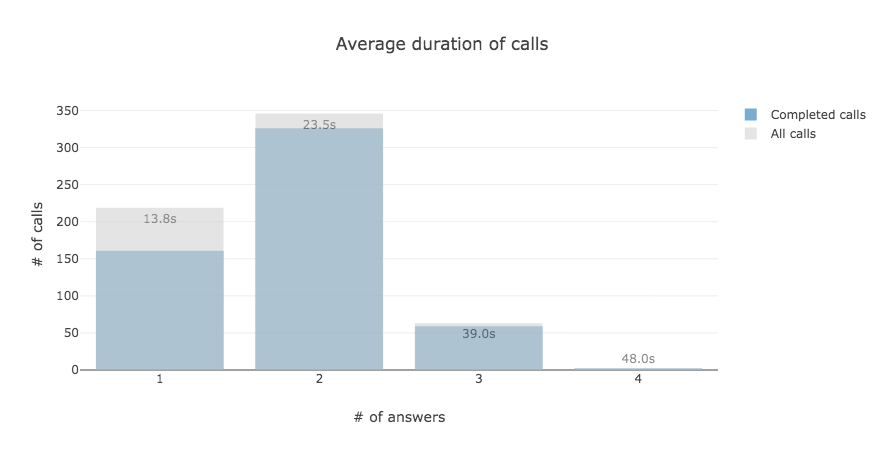

In [12]:
#text1 = [0] + [round(np.array([t['Duration'] for t in e]).mean(),1) for e in persistence.values() if len(e) > 0]
text2 = [str(round(np.array([t['Duration'] for t in e]).mean(),1))+'s' for e in persistence_all.values()]


trace1 = go.Bar(
            x=[str(k) for k in list(range(1,16))],
            y=persistence_numbers_ok,
            opacity=0.6,
            name = 'Completed calls'
            
    )

trace2 = go.Bar(
            x=[str(k) for k in list(range(1,16))],
            y=persistence_numbers_all,
            text = text2,
            textposition = 'auto',
            opacity=0.6, 
            marker=dict(color='rgba(211,211,211,1)'),
            name='All calls'
            
    )

data1 = [trace1, trace2]

layout = go.Layout(xaxis=dict(title='# of answers',type='category',showticklabels=True), yaxis=dict(title='# of calls') ,
                   title=dict(text='Average duration of calls'), barmode='overlay')

fig1 = go.Figure(data=data1, layout=layout)
pio.show(fig1)

In [49]:
pio.write_image(fig1,'images/OSN_BARCHART.pdf', width=1000, height=600)

# Customer Paths

In [28]:
paths = get_paths(files_osn)
paths_ALL = [p for p in [p['path'].split('_') for p in paths]]

paths = get_paths(files_osn_error)
paths_ERROR = [p for p in [p['path'].split('_') for p in paths]]

paths = get_paths(files_osn_hangup)
paths_HANGUP = [p for p in [p['path'].split('_') for p in paths]]

paths = get_paths(files_osn_disconnect)
paths_DISCONNECT = [p for p in [p['path'].split('_') for p in paths]]

paths = get_paths(files_osn_ok)
paths_OK = [p for p in [p['path'].split('_') for p in paths]]

In [30]:
paths_FAIL = paths_HANGUP + paths_DISCONNECT + paths_ERROR
len(paths_ALL) == len(paths_OK) + len(paths_FAIL)

True

In [32]:
sorted(paths_ALL,key=lambda x:len(x),reverse=True)[:5]

[['OpenMenu', 'OpenMenu', 'OpenMenu', 'CallSteering'],
 ['OpenMenu', 'OpenMenu', 'CallSteering', 'CallSteering'],
 ['OpenMenu', 'OpenMenu', 'CallSteering'],
 ['OpenMenu', 'OpenMenu', 'CallSteering'],
 ['OpenMenu', 'OpenMenu', 'CallSteering']]

In [107]:
x=Counter(["_".join(p) for p in paths_OK])
pprint(x.most_common(5))
path_ = x.most_common()[0][0] 
print(path_)
print(survival_prob(path_,paths_FAIL,paths_ALL))

[('OpenMenu_CallSteering', 268),
 ('OpenMenu', 161),
 ('OpenMenu_OpenMenu', 58),
 ('OpenMenu_OpenMenu_CallSteering', 36),
 ('OpenMenu_CallSteering_CallSteering', 17)]
OpenMenu_CallSteering
0.8942627655322204


In [34]:
path_ = 'OpenMenu_OpenMenu_OpenMenu_CallSteering'
print(path_)
print(survival_prob(path_,paths_FAIL,paths_ALL))
print(np.mean([p['duration'] for p in paths if p['path']==path_]),'s')

OpenMenu_OpenMenu_OpenMenu_CallSteering
0.7934907307146252
39.0 s
